In [30]:
import keras 
from keras import optimizers
from keras import losses
from keras.models import Sequential,Model
from keras.layers import Lambda ,Dense,Input,Dropout,Embedding,LSTM
from keras.optimizers import RMSprop,Adam,Nadam
from keras.preprocessing import sequence 
from keras.callbacks import TensorBoard
from keras import backend as k
from keras.losses import mse,binary_crossentropy

from keras.utils import plot_model

import sklearn
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix,roc_auc_score,classification_report
import pickle 


import seaborn as sns
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import tensorflow
import time 
import sys


In [31]:
# Visualisation class
class Visualization:
    
    labels=["Normal","Anomaly"]
    
    def drow_confusion_matrix(self,y,ypred):
        matrix=confusion_matrix(y,ypred)
        plt.figure(figsize=(15,10))
        colors=["indianred","lightseagreen"]
        sns.heatmap(matrix,xticklabels=self.labels,yticklabels=self.labels,cmap=colors,annot=True,fmt="d")
        plt.title("confusion Matrix")
        plt.ylabel('Actual')
        plt.xlabel("Predicted")
        plt.show()
    
    
    def drow_anomaly(self,y,error,threshold):
        groupsDF=pd.DataFrame({
            "error":error,
            "true":y
        }).groupby("true")
        
        figure , axes= plt.subplots(figsize=(12,8))
        for name,group in groupsDF:
            axes.plot(
                      group.index,group.error,marker="x" if name == 1 else "o",linestyle='',
                      color='r' if name==1 else "teal" , label="Anomaly" if name==1 else "Normal"
                     )
            
        axes.hlines(threshold,axes.get_xlim()[0],axes.get_xlim()[1],color="b",zorder=100,label='Thershold')
        axes.legend()
        plt.title("Anomalie")
        plt.xlabel("Data")
        plt.ylabel("Error")
        plt.show()
            
    
    def drow_error(self,error,threshold):
        plt.plot(error,marker="o",ms=3.5,linestyle="",label="Point")
        plt.hlines(threshold,xmin=0,xmax=len(error)-1,colors="b",zorder=100,label="Threshold")
        plt.legend()
        plt.title("Reconstruction Error")
        plt.ylabel("Error")
        plt.xlabel("Data")
        plt.show()
        
            

In [32]:
def transformer_df(df):
    dic={}
    for c in df.columns :
        if (df[c].dtype =="object"):
            encoder = LabelEncoder()
            encoder.fit(df[c])
            df[c]=encoder.transform(df[c])
            dic[c]=encoder
    with open("./models/LabelEncoders_dic.pickle","wb") as f:
        pickle.dump(dic,f)
    return df

In [33]:
from sklearn.utils import shuffle
def shuffle_dataframe(df):
    df = shuffle(df)
    return df

In [34]:
def normaliser_all_columns(df):
    diction={}
    for c in df.columns :
        scaler=MinMaxScaler(feature_range=(0,1)).fit(df[c].values.reshape(-1,1))
        diction[c]=scaler        
        df[c]=scaler.transform(df[c].values.reshape(-1,1))
    with open("./models/MinMaxScalers_dic.pickle","wb") as f:
        pickle.dump(diction,f)
    return df

In [35]:
df =pd.read_csv("../../data/full_data_small_datased.csv")

In [36]:
df_anomaly=df.query("Class==1")

In [37]:
df_normal=df.query("Class==0")

In [38]:
len(df_normal),len(df_anomaly)

(40395, 237665)

In [39]:
df=pd.concat([df_normal,df_anomaly])

In [40]:
df=transformer_df(df)
df=normaliser_all_columns(df)
df=shuffle_dataframe(df)

In [41]:
df.head()

,MI_dir_L5_weight,MI_dir_L5_mean,MI_dir_L5_variance,MI_dir_L3_weight,MI_dir_L3_mean,MI_dir_L3_variance,MI_dir_L1_weight,MI_dir_L1_mean,MI_dir_L1_variance,MI_dir_L0.1_weight,...,HpHp_L0.1_covariance,HpHp_L0.1_pcc,HpHp_L0.01_weight,HpHp_L0.01_mean,HpHp_L0.01_std,HpHp_L0.01_magnitude,HpHp_L0.01_radius,HpHp_L0.01_covariance,HpHp_L0.01_pcc,Class
120809,0.343327,0.894726,0.416172,0.439697,0.855455,0.633874,6.707291e-01,0.867228,8.276363e-01,0.939117,...,0.142669,0.156084,0.000000,1.000000e+00,0.000000e+00,7.865587e-01,0.000000e+00,0.135729,0.148615,1.0
209436,0.185609,0.456741,0.990106,0.292536,0.603225,0.982618,5.687946e-01,0.791952,9.167190e-01,0.908481,...,0.142669,0.156084,0.000000,4.163336e-17,0.000000e+00,2.775558e-17,0.000000e+00,0.135729,0.148615,1.0
270495,0.472166,0.342295,0.894015,0.513234,0.465958,0.983915,6.733301e-01,0.714320,9.765076e-01,0.929145,...,0.142669,0.156084,0.000000,1.000000e+00,0.000000e+00,7.865587e-01,0.000000e+00,0.135729,0.148615,1.0
27172,0.000000,0.078029,0.000000,0.000000,0.081995,0.000000,1.901148e-09,0.093898,3.901701e-08,0.000229,...,0.142669,0.156084,0.418642,7.692308e-02,2.291854e-08,1.251376e-01,2.361729e-16,0.135729,0.148615,0.0
209061,0.470903,0.648164,0.922741,0.529294,0.731267,0.861547,6.703436e-01,0.844917,8.571440e-01,0.921148,...,0.142669,0.156084,0.000000,4.163336e-17,0.000000e+00,2.775558e-17,0.000000e+00,0.135729,0.148615,1.0


In [42]:
xtrain,xtest,ytrain,ytest=train_test_split(df.drop(labels=["Class"],axis=1),df["Class"],test_size=0.2)

In [43]:
def sampling(args):
    z_mean , z_log_var=args
    batch=k.shape(z_mean)[0]
    dim=k.int_shape(z_mean)[1]
    
    epsilon=k.random_normal(shape=(batch,dim))
    return z_mean + k.exp(0.5 * z_log_var) * epsilon

In [44]:
def create_variationalModel(original_dim):
    input_shape=(original_dim,)
    intermidiate_dim=58
    batch_size=10
    latent_dim=3
    epochs=100

    inputs=Input(shape=input_shape,name="encoder_input")
    x= Dense(units=original_dim,activation="tanh")(inputs) 
    x= Dense(units=int(original_dim/2),activation="tanh")(x) 
    x1= Dense(units=int(original_dim/4),activation="tanh")(x) 
    x2= Dense(units=int(original_dim/8),activation="tanh")(x1) 
    x3= Dense(units=10,activation="tanh")(x2) 
    z_mean=Dense(latent_dim,name="z_mean")(x3)
    z_log_var=Dense(latent_dim,name="z_log_var")(x3)

    z=Lambda(sampling,output_shape=(latent_dim,),name="z")([z_mean,z_log_var])


    encoder=Model(inputs,[z_mean,z_log_var,z],name="encoder")
    encoder.summary()

    latent_inputs=Input(shape=(latent_dim,),name="z_sampling")
    x= Dense(units=10,activation="tanh")(latent_inputs) 
    x1=Dense(units=int(original_dim/8),activation="tanh")(x)
    x2=Dense(units=int(original_dim/4),activation="tanh")(x1)
    x3=Dense(units=int(original_dim/2),activation="tanh")(x2)
    x3=Dense(units=original_dim,activation="tanh")(x3)
    outputs=Dense(units=original_dim,activation="sigmoid")(x3)

    decoder=Model(latent_inputs,outputs,name="decoder")
    decoder.summary()


    outputs=decoder(encoder(inputs)[2])
    vae = Model(inputs,outputs,name="vae_mlp")


    reconstruction_loss=mse(inputs,outputs)
    reconstruction_loss*=original_dim


    kl_loss = 1 + z_log_var -k.square(z_mean) - k.exp(z_log_var)
    kl_loss=k.sum(kl_loss,axis=-1)
    kl_loss*=-0.5
    vae_loss=k.mean(reconstruction_loss+kl_loss)
    vae.add_loss(vae_loss)
    plot_model(vae,to_file='vae.png',show_shapes=True)
    vae.compile(optimizer=RMSprop(),loss="mean_squared_error",metrics=["mae"])
    return vae

In [45]:
vae=create_variationalModel(xtrain.shape[1])

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 115)          0                                            
__________________________________________________________________________________________________
dense_12 (Dense)                (None, 115)          13340       encoder_input[0][0]              
__________________________________________________________________________________________________
dense_13 (Dense)                (None, 57)           6612        dense_12[0][0]                   
__________________________________________________________________________________________________
dense_14 (Dense)                (None, 28)           1624        dense_13[0][0]                   
____________________________________________________________________________________________

In [46]:
vae.summary()

Model: "vae_mlp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 115)               0         
_________________________________________________________________
encoder (Model)              [(None, 3), (None, 3), (N 22198     
_________________________________________________________________
decoder (Model)              (None, 115)               22277     
Total params: 44,475
Trainable params: 44,475
Non-trainable params: 0
_________________________________________________________________


In [47]:
#hyperparametrs :
batchsize=100
epoch=10
start_time = time.time() 
vae.fit(xtrain,xtrain,
              batch_size=batchsize,
              epochs=epoch,
              verbose=1,
              shuffle=True,
              validation_data=(xtest,xtest),
              callbacks=[TensorBoard(log_dir="../logs/Variationalautoencoder")])
print("--- %s seconds ---" % (time.time() - start_time))    

Train on 222448 samples, validate on 55612 samples
Epoch 1/10
222448/222448 [==============================] - 7s 31us/step - loss: 2.4954 - mae: 0.0380 - val_loss: 2.0320 - val_mae: 0.0268
Epoch 2/10
222448/222448 [==============================] - 6s 29us/step - loss: 2.0562 - mae: 0.0269 - val_loss: 2.0487 - val_mae: 0.0263
Epoch 3/10
222448/222448 [==============================] - 6s 28us/step - loss: 2.0470 - mae: 0.0266 - val_loss: 2.0459 - val_mae: 0.0273
Epoch 4/10
222448/222448 [==============================] - 6s 29us/step - loss: 2.0379 - mae: 0.0265 - val_loss: 2.0418 - val_mae: 0.0270
Epoch 5/10
222448/222448 [==============================] - 6s 28us/step - loss: 2.0383 - mae: 0.0265 - val_loss: 2.0633 - val_mae: 0.0267
Epoch 6/10
222448/222448 [==============================] - 6s 28us/step - loss: 2.0473 - mae: 0.0266 - val_loss: 2.0573 - val_mae: 0.0268
Epoch 7/10
222448/222448 [==============================] - 6s 28us/step - loss: 2.0447 - mae: 0.0266 - val_loss: 2

In [48]:
%load_ext tensorboard
%tensorboard --logdir {"../logs/Variationalautoencoder/"}

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 26984), started 0:09:58 ago. (Use '!kill 26984' to kill it.)

### View the avrage length distribution of normal data

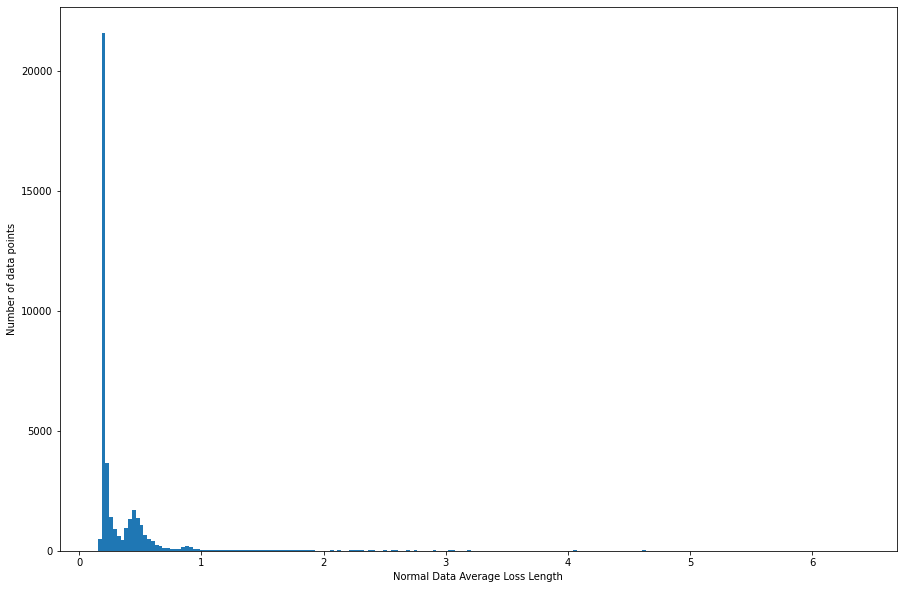

In [49]:
normal_data=df[df["Class"]==0].drop("Class",axis=1)
y_pred=vae.predict(normal_data) 
y_dist=np.linalg.norm(normal_data-y_pred,axis=-1) 

plt.figure(figsize=(15,10))
plt.hist(y_dist,bins=200)
plt.xlabel("Normal Data Average Loss Length")
plt.ylabel("Number of data points")
plt.show()

### View the avrage length distribution of anomalie data

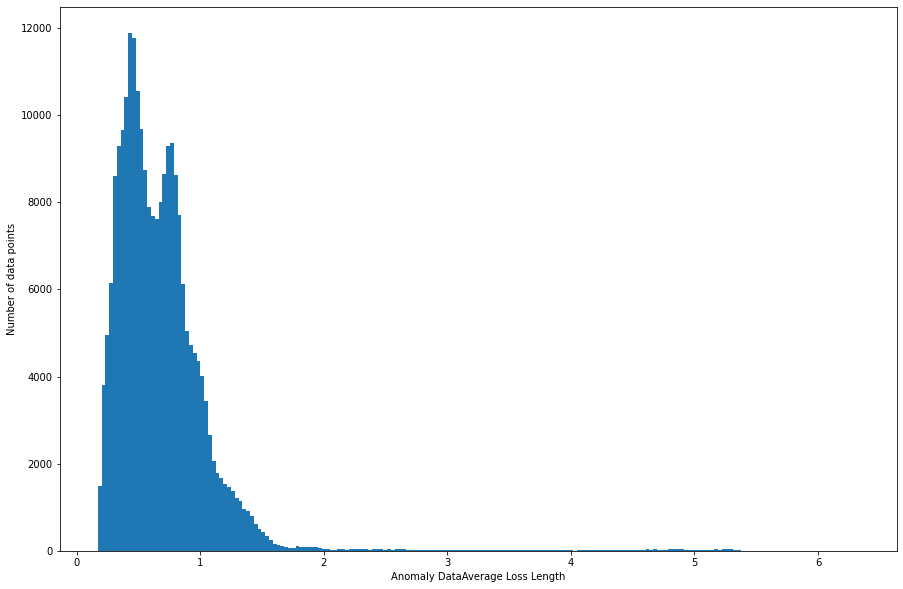

In [50]:
anomalie_data=df[df["Class"]==1].drop("Class",axis=1)
y_pred=vae.predict(anomalie_data) 
y_dist=np.linalg.norm(anomalie_data-y_pred,axis=-1)  
plt.figure(figsize=(15,10))
plt.hist(y_dist,bins=200)
plt.xlabel("Anomaly DataAverage Loss Length")
plt.ylabel("Number of data points")
plt.show()

### View the avrage length distribution of xtest data


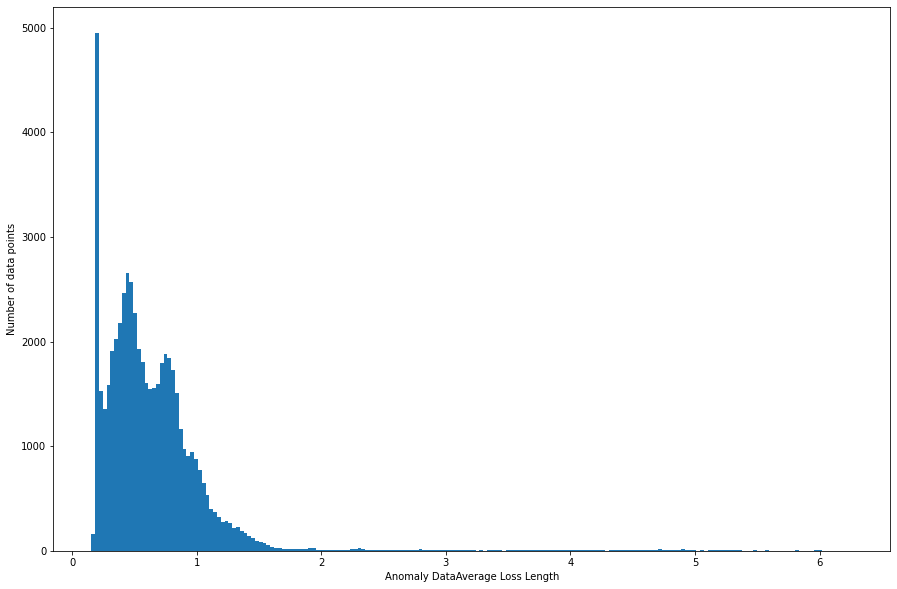

In [51]:
y_pred=vae.predict(xtest) # predicter les nouvelles transactions 
y_dist=np.linalg.norm(xtest-y_pred,axis=-1) # calculer la distance entre la valeur reel et la valeur predicter 
plt.figure(figsize=(15,10))
plt.hist(y_dist,bins=200)
plt.xlabel("Anomaly DataAverage Loss Length")
plt.ylabel("Number of data points")
plt.show()

In [52]:
def prediction(xtest):
    threshold=0.25 # le maximu distance possible pour ne considere pas comme anomalie
    start_time = time.time() 
    y_pred=vae.predict(xtest) # predicter les nouvelles transactions 
    print("--- %s seconds ---" % (time.time() - start_time))    
    y_dist=np.linalg.norm(xtest-y_pred,axis=-1) # calculer la distance entre la valeur reel et la valeur predicter 
    z=zip(y_dist >= threshold , y_dist)# retourner un tableau de True , False si ladistance superieur au threshold ou non 
    y_label=[]
    error=[]
# cree un array des 1 et 0 si anomaly ou non  
    for idx ,(is_anomaly , y_dist) in enumerate(z):
        if is_anomaly : # if the value is True : which mean the distance is sup then the threshold 
            y_label.append(1)
        else:
            y_label.append(0)
        error.append(y_dist)
    return y_label

In [53]:
y_pred=prediction(xtest)

--- 0.836510419845581 seconds ---


In [54]:
print(classification_report(ytest,y_pred))

              precision    recall  f1-score   support

         0.0       0.77      0.65      0.70      8052
         1.0       0.94      0.97      0.95     47560

    accuracy                           0.92     55612
   macro avg       0.85      0.81      0.83     55612
weighted avg       0.92      0.92      0.92     55612



In [55]:
print('precision_score : '+str(precision_score(ytest, y_pred, average='weighted')))
print('accuracy_score : '+str(accuracy_score(ytest, y_pred)))
print('recall_score : '+str(recall_score(ytest, y_pred, average='weighted')))
print('f1_score : '+str(f1_score(ytest, y_pred, average='weighted')))
print('roc_auc_score : '+str(roc_auc_score(ytest,y_pred))) # TruePositive,TrueNegative
tn, fp, fn, tp = confusion_matrix(ytest, y_pred).ravel()
print('True_positive : '+str(tp)+', False_positive : '+str(fp)+', True_negative : '+str(tn)+', False_negative : '+str(fn))

precision_score : 0.9163454205049532
accuracy_score : 0.9203409336114508
recall_score : 0.9203409336114508
f1_score : 0.9174457106986269
roc_auc_score : 0.8063115715051492
True_positive : 45982, False_positive : 2852, True_negative : 5200, False_negative : 1578


In [56]:
viz=Visualization()

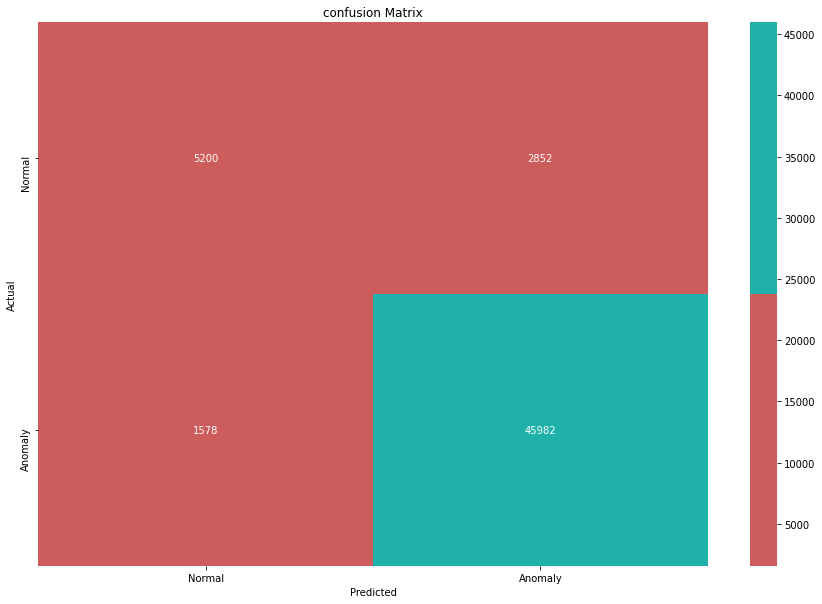

In [57]:
viz.drow_confusion_matrix(ytest,y_pred)

In [58]:
vae.save("./models/vae.h5")

In [40]:
with open("./models/vae.pickle","wb") as f:
        pickle.dump(vae,f)